In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [84]:
df=pd.read_csv('pact_20200703T210016.csv')
df['RADIATION']=0.234897256+0.732700955*np.cos(np.pi/12*(((pd.to_datetime(d['TIMESTAMP'])-pd.Timestamp('13:13:02'))/pd.Timedelta(hours=1)).mod(24)))

In [94]:
X = pd.DataFrame([10**((11.5511+df['TX POWER']-df['RSSI'])/20),df['RADIATION']]).T
y = np.ravel(df['DISTANCE'])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [96]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [97]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', activation='relu', input_shape=(2,)))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss=tf.keras.losses.Huber(delta=70.0),
              optimizer='sgd',
              metrics=['msle','logcosh','mse'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(X_train, y_train, epochs=8, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Train on 466235 samples, validate on 229639 samples
Epoch 1/8
466235/466235 [==============================] - 55s 117us/sample - loss: 0.1709 - msle: 0.0644 - logcosh: 0.1551 - mse: 0.3419 - val_loss: 0.1674 - val_msle: 0.0626 - val_logcosh: 0.1526 - val_mse: 0.3349
Epoch 2/8
466235/466235 [==============================] - 50s 107us/sample - loss: 0.1675 - msle: 0.0627 - logcosh: 0.1526 - mse: 0.3350 - val_loss: 0.1675 - val_msle: 0.0630 - val_logcosh: 0.1526 - val_mse: 0.3349
Epoch 3/8
466235/466235 [==============================] - 63s 134us/sample - loss: 0.1674 - msle: 0.0627 - logcosh: 0.1526 - mse: 0.3349 - val_loss: 0.1673 - val_msle: 0.0626 - val_logcosh: 0.1525 - val_mse: 0.3347
Epoch 4/8
466235/466235 [==============================] - 60s 129us/sample - loss: 0.1674 - msle: 0.0627 - logcosh: 0.1525 - mse: 0.3347 - val_loss: 0.1672 - val_msle: 0.0627 - val_logcosh: 0.1524 - val_mse: 0.3345
Epoch 5/8
466235/466235 [==============================] - 58s 123us/sample - loss: 

In [99]:
model.save('model-rssi-time')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-rssi-time\assets


In [100]:
X_predict=scaler.transform(X)
df['PREDICTION']=model.predict(X_predict, verbose=1)

695874/695874 [==============================] - 26s 37us/sample


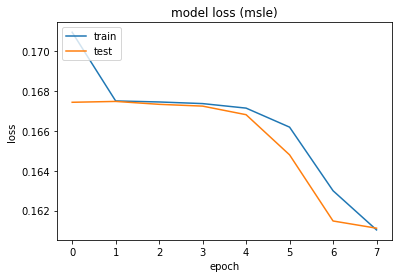

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (msle)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

ML model mean squared log error is 0.010761.
False positive rate is 0.000%.
False negative rate is 19.683%.
True positive rate is 0.000%.
True negative rate is 80.317%.


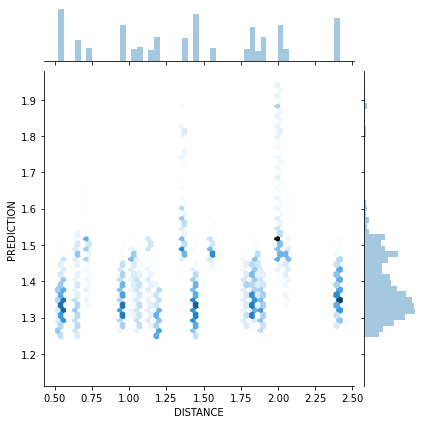

In [102]:
print("ML model mean squared log error is {0:.5}.".format(np.sum(df['SLE'])/len(d)))
print("False positive rate is {0:.3%}.".format(len(df.query('DISTANCE>0.9144 and PREDICTION<=0.9144'))/len(d)))
print("False negative rate is {0:.3%}.".format(len(df.query('DISTANCE<=0.9144 and PREDICTION>0.9144'))/len(d)))
print("True positive rate is {0:.3%}.".format(len(df.query('DISTANCE<=0.9144 and PREDICTION<=0.9144'))/len(d)))
print("True negative rate is {0:.3%}.".format(len(df.query('DISTANCE>0.9144 and PREDICTION>0.9144'))/len(d)))
plot_data=df.query('`PREDICTION`>0 and `PREDICTION`<4')
sns.jointplot(x="DISTANCE", y="PREDICTION", data=plot_data, kind="hex")